In [1]:
# TODO allow Monte Carlo runs on output data structure

In [2]:
# cadCAD Open Questions

# 1. Is it possible to run substeps (PSubs) in a non-deterministic order? Or order that was determined by a function that's output changes each step?
# 2. How to best handle variables that are only relevant in the step? Or across substeps?
# 3. Can you update multiple state variables in a single policy without doing this silly dictionary pass I've done? Or is it possible to immediately update the state variable itself instead of waiting for state update?
# 4. Can initial conditions be non-deterministic? Can I pass in a random number generator that acts as the dataset, and will it generate new random numbers each Monte Carlo run?
# 5. Need to walk through an ideal model map with somebody. How can I build in a market? Starting to see the light but still wrapped up in fitting within structure
# 6. can't have two functions updating same state variable in the same substep

# Power to the People Hackathon
## Energy System Dynamics

### Import Libraries

In [3]:
import random
import math
import numpy as np

### Set Simulation Parameters

In [4]:
plot = True
# simulation parameters
days_to_simulate = 365*15 # days to simulate
# revenues
price_per_kwh = 0.07 # cost per kwh of electricity
max_price_per_kwh = 0.13 # max cost of electricity
# operating decisions
production_decay_rate = 0.99992 # decay rate of equimpent (solartainer production, battery max level)
maintenance_rate = 150 # days between maintenance
# operating costs
op_cost_per_hour = 0.1 # operating costs per hour of operation
op_cost_per_kwh = 0.035 # operating cost per kwh produced
maintenance_cost_per = 300 # maintenance cost per time maintained (increases production capability of equipment back to 100%)

### Set Initial Conditions

In [5]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# List of all the state variables in the system and their initial values
initial_conditions = {
    # INITIAL CONDITIONS TO PLAY WITH
    'bat_lim': 25, # max kWh able to be stored in battery
    'price_per_kwh': {'price': price_per_kwh, 'max_price': max_price_per_kwh, 'min_price': 0.0}, # EUR cents
    'maintenance_rate': maintenance_rate, # days between each maintenance call
    # INITIAL CONDITIONS TO LET BE, but no hard rules on that :)
    # initial ownership breakdown
    'ownership': {'solartainer': 1., 'operator': 0., 'priority': 0., 'business': 0., 'leisure': 0., 'maintenance': 0., 'crowdfunders': 0.},
    # total tracking of max values
    'energy_prod': {'available': 0., 'remaining': 0.}, # total energy produced by the system per timestep
    'energy_appetite': {'priority': 0., 'business': 0., 'leisure': 0.}, # amount of energy appetite
    # total tracking of actual usage
    'energy_cons': {'tot': 0, 'prod': 0., 'bat_use': 0., 'priority': 0., 'business': 0., 'leisure': 0., 'bybat': 0}, # total energy consumed
    'energy_revenue': {'tot': 0, 'prod': 0., 'bat_use': 0., 'priority': 0., 'business': 0., 'leisure': 0., 'bybat': 0}, # total energy consumed
    # time tracking
    'hour': 0,
    # track when maintenance occurs (binary)
    'maintenance_cost': {'maintenance_cost': 0, 'maintenance_occured': 0, 'maintenance_cost_per': maintenance_cost_per},
    'op_cost': {'operations': op_cost_per_hour, 'op_cost_per_kwh': op_cost_per_kwh}, # 4 EUR cents per kwh of operations, 10 EUR cents per hour of operations
    # track time-based variances
    'annual_var': {'prod': 0., 'priority': 0., 'business': 0., 'leisure': 0.},
    'daily_mult': {'prod': .8, 'priority': .8, 'business': .8, 'leisure': .8},
    # limited mechanics tracking
    'bat_level': 0, # amount of energy currently stored in the battery  
    'production_efficiency': {'value': 1., 'decay': production_decay_rate} # % of production and battery storage usable, decay=0.9999 to start
}
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

### Generate Data Functions

In [6]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# Specify the energy generation and usage functions

def hourly_production_capacity(params, step, sL, s):
    hourly_0_prod_chance = 0.1
    hour = s['hour']
    # set cosine function attributes
    y_int = 33 # tuned to make energy output over year match reported 59000 per Solartainer
    cos_mult = 2.
    x_mult = 1./365/24*2*np.pi
    # get variances
    # get annual mu
    if hour % (365*24) == 0:
        mu, sigma = y_int, .03 * y_int
        annual_var = np.random.normal(mu, sigma, 1)[0]
    else:
        annual_var = s['annual_var']['prod']
    # get daily mu
    # daily (multiplier)
    if hour % 24 == 0:
        mu, sigma = 0.8, .2
        daily_mult = abs(np.random.normal(mu, sigma, 1)[0])
    else:
        daily_mult = s['daily_mult']['prod']
    # hourly var
    mu, sigma = annual_var, .1 * annual_var
    hourly_var = np.random.normal(mu, sigma, 1)[0]
    # hourly mult
    hourly_mult = max(np.sin((hour)/24*2*np.pi - np.pi/2) + 0.5, 0)
    if random.random() < hourly_0_prod_chance:
        hourly_mult = 0
    # get core waveform
    prod = ((cos_mult * np.cos(step * x_mult) + hourly_var) * daily_mult) * hourly_mult
    # set limits
    prod = max(0, prod) # must be >= 0
    prod = min(prod, y_int) # maximum generation capacity of equipment per hour
    prod *= s['production_efficiency']['value']
    return(prod, annual_var, daily_mult)

def hourly_usage_appetite(params, step, sL, s, tier):
    hour = s['hour']
    # get different cosine manipulators for each tier of user
    if tier == 'priority':
        y_int = 9
        annual_var = s['annual_var']['priority']
        daily_mult = s['daily_mult']['priority']
        daily_mult_sigma = 0.01
        cos_mult = 0.1
        hourly_cos_mult = 0.1
        hourly_sig = 0.01
    if tier == 'business':
        y_int = 3 / (s['price_per_kwh']['price'] / s['price_per_kwh']['max_price'])
        annual_var = s['annual_var']['business']
        daily_mult = s['daily_mult']['business']
        daily_mult_sigma = 0.1
        cos_mult = 0.5
        hourly_cos_mult = 0.8
        hourly_sig = 0.1
    if tier == 'leisure':
        y_int = 3 / (s['price_per_kwh']['price'] / s['price_per_kwh']['max_price'])
        annual_var = s['annual_var']['leisure']
        daily_mult = s['daily_mult']['leisure']
        daily_mult_sigma = 0.2
        cos_mult = 1.2
        hourly_cos_mult = 1.0
        hourly_sig = 0.2
    # set cosine function attributes
    x_mult = 1./365/24*2*np.pi
    # get variances
    # get annual mu
    if hour % (365*24) == 0:
        mu, sigma = y_int, .03 * y_int
        annual_var = np.random.normal(mu, sigma, 1)[0]
    # get daily mu
    # daily (multiplier)
    if hour % 24 == 0:
        mu, sigma = 0.8, daily_mult_sigma
        daily_mult = abs(np.random.normal(mu, sigma, 1)[0])
    # hourly var
    mu, sigma = annual_var, hourly_sig * annual_var
    hourly_var = np.random.normal(mu, sigma, 1)[0]
    # hourly mult
    hourly_mult = max(hourly_cos_mult * (np.sin((hour)/24*4*np.pi - np.pi/2)+0.5*np.sin((hour)/24*2*np.pi - np.pi/2)) + 0.8, 0)
    # get core waveform
    cons = ((cos_mult * np.sin(step * x_mult) + hourly_var) * daily_mult) * hourly_mult
    # set limits
    cons = max(0, cons) # must be >= 0
    cons = min(cons, y_int) # maximum usage appetite per hour
    return(cons, annual_var, daily_mult)

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

### Specify Agent Energy Consumption Functions

In [7]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #  
# Specify the Solartainer production and battery logic in a Policy function
def solartainer_produce(params, step, sL, s):
    # calculate production from random variables
    energy_prod_remaining, annual_var, daily_mult = hourly_production_capacity(params, step, sL, s)
    if s['hour'] % (24*10) == 0: # print day every 10 days
        print("year:", int(s['hour']/24/365.),"day:", int(s['hour']/24)%365)
    # reset state trackers
    energy_prod_ = s['energy_prod'] # total energy produced by the system per timestep
    energy_prod_['available'] = energy_prod_remaining
    energy_prod_['remaining'] = energy_prod_remaining
    annual_var_ = s['annual_var']
    annual_var_['prod'] = annual_var
    daily_mult_ = s['daily_mult']
    daily_mult_['prod'] = daily_mult
    return({'energy_prod': energy_prod_,
            'annual_var': annual_var_,
            'daily_mult': daily_mult_
            })

# Specify the user of electricity logic in a Policy function
def consume_electricity(params, step, sL, s, energy_appetite, use_bat):
    energy_avail_prod = s['energy_prod']['remaining']
    energy_cons_prod = min(energy_avail_prod, energy_appetite)
    # TODO can you change the circumstances under which the user uses the battery? Sounds exciting!
    if use_bat:
        energy_cons_bat = min(energy_appetite - energy_cons_prod, s['bat_level'])
    else:
        energy_cons_bat = 0
    return(energy_cons_prod, energy_cons_bat)

def userGroup_usage(params, step, sL, s, tier):
    # calculate energy appetite from random variables, something about the state?
    energy_appetite, annual_var, daily_mult = hourly_usage_appetite(params, step, sL, s, tier=tier)
    # consume electricity based on appetite
    energy_cons_prod, energy_cons_bat = consume_electricity(params, step, sL, s, energy_appetite, use_bat=True)
    # prepare dictionaries
    # appetite
    energy_appetite_ = s['energy_appetite']
    energy_appetite_[tier] = energy_appetite
    # energy consumption
    energy_cons_ = s['energy_cons']
    energy_cons_[tier] += (energy_cons_prod + energy_cons_bat)
    energy_cons_['tot'] += energy_cons_prod
    energy_cons_['prod'] += energy_cons_prod
    energy_cons_['bat_use'] += energy_cons_bat
    # revenues from sale
    energy_revenue_ = s['energy_revenue']
    energy_revenue_[tier] += (energy_cons_prod + energy_cons_bat) * s['price_per_kwh']['price']
    energy_revenue_['tot'] += (energy_cons_prod + energy_cons_bat) * s['price_per_kwh']['price']
    energy_revenue_['prod'] += energy_cons_prod * s['price_per_kwh']['price']
    energy_revenue_['bat_use'] += energy_cons_bat * s['price_per_kwh']['price']
    # operating costs
    op_cost_ = s['op_cost']
    op_cost_['operations'] += (energy_cons_prod + energy_cons_bat) * s['op_cost']['op_cost_per_kwh']
    # production tracking
    energy_prod_ = s['energy_prod']
    energy_prod_['remaining'] -= energy_cons_prod
    # variances
    annual_var_ = s['annual_var']
    annual_var_[tier] = annual_var
    daily_mult_ = s['daily_mult']
    daily_mult_[tier] = daily_mult
    return({'energy_appetite': energy_appetite_,
            'energy_cons': energy_cons_, 
            'op_cost': op_cost_,
            'energy_revenue': energy_revenue_,
            'energy_prod': energy_prod_,
            'bat_use': energy_cons_bat,
            'annual_var': annual_var_,
            'daily_mult': daily_mult_})

# Specify the individual policy functions of the electricity consumers and battery
def userGroup_priority(params, step, sL, s):
    tier = 'priority'
    return userGroup_usage(params, step, sL, s, tier)

def userGroup_business(params, step, sL, s):
    tier = 'business'
    return userGroup_usage(params, step, sL, s, tier)

def userGroup_leisure(params, step, sL, s):
    tier = 'leisure'
    return userGroup_usage(params, step, sL, s, tier)

# Specify the actions of the battery based on leftover electricity
def battery_tracker(params, step, sL, s):
    # calculate energy appetite based on battery cap
    energy_appetite = s['bat_lim']*s['production_efficiency']['value'] - s['bat_level']
    # consume electricity based on appetite
    energy_cons_prod, energy_cons_bat = consume_electricity(params, step, sL, s, energy_appetite, use_bat=False)
    #energy_cons_ = s['energy_cons']
    energy_cons_ = s['energy_cons']
    energy_cons_['bybat'] = energy_cons_prod
    energy_cons_['bat_use'] += energy_cons_bat
    energy_cons_['tot'] += (energy_cons_prod)
    op_cost_ = s['op_cost']
    op_cost_['operations'] += (energy_cons_prod) * s['op_cost']['op_cost_per_kwh'] / 2
    return({'energy_cons': energy_cons_,
            'op_cost': op_cost_,
            'bat_use': 0,
            'hour_inc': 1})

# Specify maintenance schedule
def maintenance(params, step, sL, s):
    # TODO this looks like it would be fun to play with as a hacker!
    maintenance_ = s['maintenance_cost']
    if (s['hour']+1) % (s['maintenance_rate']*24) == 0:
        maintenance_['maintenance_occured'] = 1
        maintenance_['maintenance_cost'] = maintenance_['maintenance_cost_per']
    else:
        maintenance_['maintenance_occured'] = 0
        maintenance_['maintenance_cost'] = 0
    return({'maintenance_cost': maintenance_})

def ownership_dynamics(params, step, sL, s):
    # currently set to stay the same over the entire time period
    # TODO maybe you can play with the ownership model dynamics here based on consumption? or revenues?
    ownership_ = s['ownership']
    return({'ownership': ownership_})

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

### Define State Update Functions

In [8]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# We make the state update functions less "intelligent",
# ie. they simply add the amount of electricity produced / consumed

# set    

# update potential max values
def set_energy_prod(params, step, sL, s, _input):
    y = 'energy_prod'
    x = {'available': 0., 'remaining': 0.}
    return (y, x)

def set_energy_appetite(params, step, sL, s, _input):
    y = 'energy_appetite'
    x = {'priority': 0., 'business': 0., 'leisure': 0.}
    return (y, x)

# update actual use values
def set_energy_cons(params, step, sL, s, _input):
    y = 'energy_cons'
    x = {'tot': 0, 'prod': 0., 'bat_use': 0., 'priority': 0., 'business': 0., 'leisure': 0., 'bybat': 0}
    return (y, x)

# costs and revenues
def set_energy_revenue(params, step, sL, s, _input):
    y = 'energy_revenue'
    x = {'tot': 0, 'prod': 0., 'bat_use': 0., 'priority': 0., 'business': 0., 'leisure': 0., 'bybat': 0}
    return (y, x) 

def set_op_cost(params, step, sL, s, _input):
    y = 'op_cost'
    x = {'operations': op_cost_per_hour, 'op_cost_per_kwh': op_cost_per_kwh}
    return (y, x) 

def set_maintenance_cost(params, step, sL, s, _input):
    y = 'maintenance_cost'
    x = _input['maintenance_cost']
    return (y, x)    

# increments

def increment_energy_prod(params, step, sL, s, _input):
    y = 'energy_prod'
    x = _input['energy_prod']
    return (y, x)

def increment_energy_appetite(params, step, sL, s, _input):
    y = 'energy_appetite'
    x = _input['energy_appetite']
    return (y, x)

# update actual use values
def increment_energy_cons(params, step, sL, s, _input):
    y = 'energy_cons'
    x = _input['energy_cons']
    return (y, x)

# update battery state
def increment_bat_level(params, step, sL, s, _input):
    y = 'bat_level'
    x = s['bat_level'] + _input['energy_cons']['bybat'] - _input['bat_use']
    return (y, x)

# update input variances
def update_annual_var(params, step, sL, s, _input):
    y = 'annual_var'
    x = _input['annual_var']
    return (y, x)

def update_daily_mult(params, step, sL, s, _input):
    y = 'daily_mult'
    x = _input['daily_mult']
    return (y, x)

# update tracker of hours passed
def increment_hour(params, step, sL, s, _input):
    y = 'hour'
    x = s['hour'] + _input['hour_inc']
    return (y, x)

# degrade operational efficiency
def increment_production_efficiency(params, step, sL, s, _input):
    y = 'production_efficiency'
    x = s['production_efficiency']
    x['value'] *= x['decay']
    if s['maintenance_cost']['maintenance_occured'] == 1:
        x['value'] = 1.
    return (y, x)

def set_maintenance_occured(params, step, sL, s, _input):
    y = 'maintenance_occured'
    x = _input['maintenance_occured']
    return (y, x)

# update costs
def increment_energy_revenue(params, step, sL, s, _input):
    y = 'energy_revenue'
    x = _input['energy_revenue']
    return (y, x)

def increment_op_cost(params, step, sL, s, _input):
    y = 'op_cost'
    x = _input['op_cost']
    return (y, x)

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# TODO here is where you could play with how some policy updates occur

# update price of electricity
def update_price_per_kwh(params, step, sL, s, _input):
    y = 'price_per_kwh'
    price = max(min(s['price_per_kwh']['price'], s['price_per_kwh']['max_price']),s['price_per_kwh']['min_price']) # make sure in bounds
    x = s['price_per_kwh']
    x['price'] = price
    return (y, x)

# update ownership
def update_ownership(params, step, sL, s, _input):
    y = 'ownership'
    x = _input['ownership']
    return (y, x)

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

### Define Partial State Update Blocks

In [9]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# In the Partial State Update Blocks, 
# the user specifies if state update functions will be run in series or in parallel
# and the policy functions that will be evaluated in that block
user_variables = { # The following state variables will be updated simultaneously
            'energy_appetite': increment_energy_appetite,
            'energy_cons': increment_energy_cons,
            'bat_level': increment_bat_level,
            'annual_var': update_annual_var,
            'daily_mult': update_daily_mult,
            'energy_revenue': increment_energy_revenue,
            'op_cost': increment_op_cost
        }

partial_state_update_blocks = [
    { # Maintenance if needed
        'policies': { # The following policy functions will be evaluated and their returns will be passed to the state update functions
            'maintenance': maintenance
        },
        'variables': { # The following state variables will be updated simultaneously
            'maintenance_cost': set_maintenance_cost,
        }
    },
    { # Get energy available to be used in this timestep
        'policies': { # The following policy functions will be evaluated and their returns will be passed to the state update functions
            'solartainer_produce': solartainer_produce
        },
        'variables': { # The following state variables will be updated simultaneously
            'energy_prod': set_energy_prod,
            'energy_appetite': set_energy_appetite,
            'energy_cons': set_energy_cons,
            'energy_prod': increment_energy_prod,
            'annual_var': update_annual_var,
            'daily_mult': update_daily_mult,
            'price_per_kwh': update_price_per_kwh,
            'energy_revenue': set_energy_revenue,
            'op_cost': set_op_cost
        }
    },
    { # Get priority users usage (Tier 1 users)
        'policies': { # The following policy functions will be evaluated and their returns will be passed to the state update functions
            'userGroup_priority': userGroup_priority
        },
        'variables': user_variables
    },
    { # Get business users usage (Tier 2 users)
        'policies': { # The following policy functions will be evaluated and their returns will be passed to the state update functions
            'userGroup_business': userGroup_business
        },
        'variables': user_variables
    },
    { # Get leisure users usage (Tier 3 users)
        'policies': { # The following policy functions will be evaluated and their returns will be passed to the state update functions
            'userGroup_leisure': userGroup_leisure
        },
        'variables': user_variables
    },
    { # Get battery usage (Tier 4)
        'policies': { # The following policy functions will be evaluated and their returns will be passed to the state update functions
            'battery_tracker': battery_tracker,
        },
        'variables': { # The following state variables will be updated simultaneously
            'energy_cons': increment_energy_cons,
            'op_cost': increment_op_cost,
            'bat_level': increment_bat_level,
            'hour': increment_hour
        }
    },
    { # Operate on ownership
        'policies': { # The following policy functions will be evaluated and their returns will be passed to the state update functions
            'ownership_dynamics': ownership_dynamics,
        },
        'variables': { # The following state variables will be updated simultaneously
            'ownership': update_ownership
        }
    }
]
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

### Run cadCAD

In [10]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# Settings of general simulation parameters, unrelated to the system itself
# `T` is a range with the number of discrete units of time the simulation will run for;
# `N` is the number of times the simulation will be run (Monte Carlo runs)
# `M` is not currently used

simulation_parameters = {
    'T': range(24*days_to_simulate),
    'N': 1,
    'M': {}
}
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

from cadCAD.configuration import Configuration
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# The configurations above are then packaged into a `Configuration` object
config = Configuration(initial_state=initial_conditions, #dict containing variable names and initial values
                       partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
                       sim_config=simulation_parameters #dict containing simulation parameters
                      )

from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
exec_mode = ExecutionMode()
exec_context = ExecutionContext(exec_mode.single_proc)
executor = Executor(exec_context, [config]) # Pass the configuration object inside an array
raw_result, tensor = executor.execute() # The `execute()` method returns a tuple; its first elements contains the raw results


raw_result = [d for d in raw_result if d['substep'] == len(partial_state_update_blocks)]


                            __________   ____ 
          ________ __ _____/ ____/   |  / __ \
         / ___/ __` / __  / /   / /| | / / / /
        / /__/ /_/ / /_/ / /___/ ___ |/ /_/ / 
        \___/\__,_/\__,_/\____/_/  |_/_____/  
        by BlockScience
        
Execution Mode: single_proc: [<cadCAD.configuration.Configuration object at 0x000001D8A7ACC358>]
Configurations: [<cadCAD.configuration.Configuration object at 0x000001D8A7ACC358>]
year: 0 day: 0
year: 0 day: 10
year: 0 day: 20
year: 0 day: 30
year: 0 day: 40
year: 0 day: 50
year: 0 day: 60
year: 0 day: 70
year: 0 day: 80
year: 0 day: 90
year: 0 day: 100
year: 0 day: 110
year: 0 day: 120
year: 0 day: 130
year: 0 day: 140
year: 0 day: 150
year: 0 day: 160
year: 0 day: 170
year: 0 day: 180
year: 0 day: 190
year: 0 day: 200
year: 0 day: 210
year: 0 day: 220
year: 0 day: 230
year: 0 day: 240
year: 0 day: 250
year: 0 day: 260
year: 0 day: 270
year: 0 day: 280
year: 0 day: 290
year: 0 day: 300
year: 0 day: 310
year: 0 day: 320


year: 13 day: 165
year: 13 day: 175
year: 13 day: 185
year: 13 day: 195
year: 13 day: 205
year: 13 day: 215
year: 13 day: 225
year: 13 day: 235
year: 13 day: 245
year: 13 day: 255
year: 13 day: 265
year: 13 day: 275
year: 13 day: 285
year: 13 day: 295
year: 13 day: 305
year: 13 day: 315
year: 13 day: 325
year: 13 day: 335
year: 13 day: 345
year: 13 day: 355
year: 14 day: 0
year: 14 day: 10
year: 14 day: 20
year: 14 day: 30
year: 14 day: 40
year: 14 day: 50
year: 14 day: 60
year: 14 day: 70
year: 14 day: 80
year: 14 day: 90
year: 14 day: 100
year: 14 day: 110
year: 14 day: 120
year: 14 day: 130
year: 14 day: 140
year: 14 day: 150
year: 14 day: 160
year: 14 day: 170
year: 14 day: 180
year: 14 day: 190
year: 14 day: 200
year: 14 day: 210
year: 14 day: 220
year: 14 day: 230
year: 14 day: 240
year: 14 day: 250
year: 14 day: 260
year: 14 day: 270
year: 14 day: 280
year: 14 day: 290
year: 14 day: 300
year: 14 day: 310
year: 14 day: 320
year: 14 day: 330
year: 14 day: 340
year: 14 day: 350
yea

In [11]:
### Data Save / Load Helper Functions

In [12]:
# Get data in an easier to reference frame
%matplotlib inline
import pandas as pd
df = np.asarray(raw_result)
df2 = {k: [dic[k] for dic in df] for k in df[0]}
inverts = ['price_per_kwh', 'maintenance_cost', 'ownership', 'energy_prod', 'energy_appetite', 'energy_cons', 'annual_var', 'daily_mult', 'op_cost', 'energy_revenue']
for invert in inverts:
    df3 = df2.copy()
    df3[invert] = {k: [dic[k] for dic in df2[invert]] for k in df2[invert][0]}
    df2 = df3.copy()
df = df2.copy() 

In [13]:
# Output into csv
import pickle
def save_obj(obj, name):
    num = str(int(random.random()*100))
    with open('data_pregenerated/'+name + num + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

# you can load objects from csv like this
def load_obj(name):
    with open('data/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

save_obj(df, 'data')

### Plot Some Stuff

----------------------------
kwh produced: 1111137 of 1744410 available which is 64.0 % capacity
total appetite was: 1600961
leaving 489824 kwh instead generated by diesel which is 31.0 %
over 131400 hours
total revenues EUR 77779 with op cost 55156 and maintenance 10800 occuring 36 times
kwh produced: 1111137 with 178674 being routed through battery and 932463 directly from Solartainer
priority users used 496809 out of 746673 appetite
business users used 327834 out of 435139 appetite
leisure users used 286494 out of 419149 appetite
-----------------------------


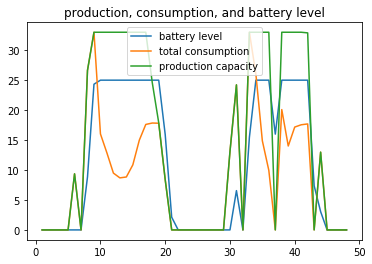

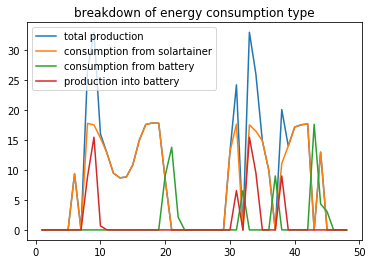

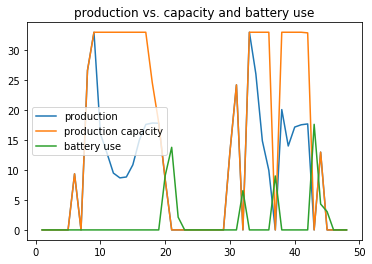

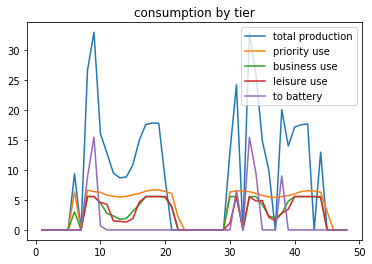

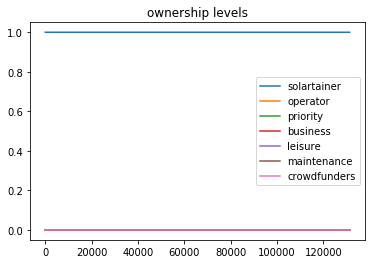

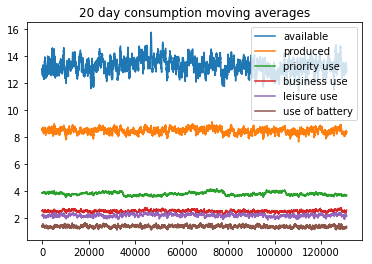

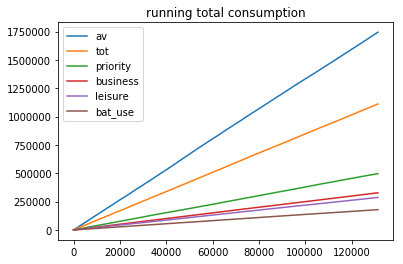

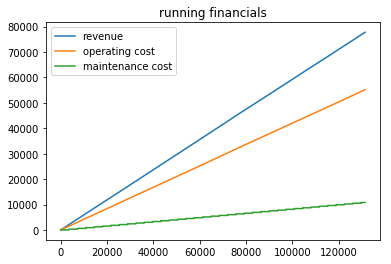

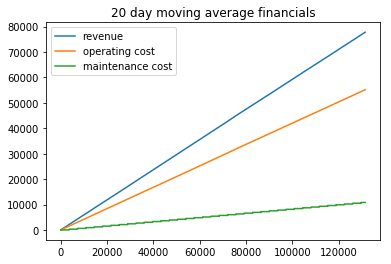

In [14]:
import matplotlib.pyplot as plt

av = int(sum(df['energy_prod']['available']))
tot = int(sum(df['energy_cons']['tot']))
tot_revenue = int(sum(df['energy_revenue']['tot']))
tot_op_cost = int(sum(df['op_cost']['operations']))
maintenance_count = int(sum(df['maintenance_cost']['maintenance_occured']))
maintenance_cost = int(sum(df['maintenance_cost']['maintenance_cost']))
priority = int(sum(df['energy_cons']['priority']))
business = int(sum(df['energy_cons']['business']))
leisure = int(sum(df['energy_cons']['leisure']))
priority_app = int(sum(df['energy_appetite']['priority']))
business_app = int(sum(df['energy_appetite']['business']))
leisure_app = int(sum(df['energy_appetite']['leisure']))
bat_use = int(sum(df['energy_cons']['bat_use']))
bat = int(sum(df['energy_cons']['bybat']))
prod = int(sum(df['energy_cons']['prod']))

print('----------------------------')
print('kwh produced:', tot,'of', av,'available which is', np.round(100.*tot/av,),'% capacity')
app_tot = priority_app+business_app+leisure_app
print('total appetite was:', app_tot)
print('leaving', app_tot - tot, 'kwh instead generated by diesel which is', np.round(100*((app_tot - tot) / app_tot),0),'%')

print('over', max(df['hour']), 'hours')
print('total revenues EUR', tot_revenue, 'with op cost', tot_op_cost, 'and maintenance', maintenance_cost, 'occuring', maintenance_count, 'times')
print('kwh produced:', tot, 'with', bat_use, 'being routed through battery and', prod,'directly from Solartainer')
print('priority users used', priority, 'out of', priority_app, 'appetite')
print('business users used', business, 'out of', business_app, 'appetite')
print('leisure users used', leisure, 'out of', leisure_app, 'appetite')
print('-----------------------------')

def moving_average(mylist, N=24*20):
    cumsum, moving_aves = [0], []
    for i, x in enumerate(mylist, 1):
        cumsum.append(cumsum[i-1] + x)
        if i>=N:
            moving_ave = (cumsum[i] - cumsum[i-N])/N
            moving_aves.append(moving_ave)
    return cumsum, moving_aves

av = moving_average(df['energy_prod']['available'])
tot = moving_average(df['energy_cons']['tot'])
tot_revenue = moving_average(df['energy_revenue']['tot'])
tot_op_cost = moving_average(df['op_cost']['operations'])
maintenance_count = moving_average(df['maintenance_cost']['maintenance_occured'])
maintenance_cost = moving_average(df['maintenance_cost']['maintenance_cost'])
priority = moving_average(df['energy_cons']['priority'])
business = moving_average(df['energy_cons']['business'])
leisure = moving_average(df['energy_cons']['leisure'])
priority_app = moving_average(df['energy_appetite']['priority'])
business_app = moving_average(df['energy_appetite']['business'])
leisure_app = moving_average(df['energy_appetite']['leisure'])
bat_use = moving_average(df['energy_cons']['bat_use'])
bat = moving_average(df['energy_cons']['bybat'])
prod = moving_average(df['energy_cons']['prod'])

plot_distance = 24 * 2
if plot:
    # plot 
    plt.plot(df['timestep'][0:plot_distance], df['bat_level'][0:plot_distance], label='battery level')
    plt.plot(df['timestep'][0:plot_distance], df['energy_cons']['tot'][0:plot_distance], label='total consumption')
    plt.plot(df['timestep'][0:plot_distance], df['energy_prod']['available'][0:plot_distance], label='production capacity')
    plt.legend()
    plt.title('production, consumption, and battery level')
    plt.show()

    plt.plot(df['timestep'][0:plot_distance], df['energy_cons']['tot'][0:plot_distance], label='total production')
    plt.plot(df['timestep'][0:plot_distance], df['energy_cons']['prod'][0:plot_distance], label='consumption from solartainer')
    plt.plot(df['timestep'][0:plot_distance], df['energy_cons']['bat_use'][0:plot_distance], label='consumption from battery')
    plt.plot(df['timestep'][0:plot_distance], df['energy_cons']['bybat'][0:plot_distance], label='production into battery')
    plt.legend()
    plt.title('breakdown of energy consumption type')
    plt.show()

    plt.plot(df['timestep'][0:plot_distance], df['energy_cons']['tot'][0:plot_distance], label='production')
    plt.plot(df['timestep'][0:plot_distance], df['energy_prod']['available'][0:plot_distance], label='production capacity')
    plt.plot(df['timestep'][0:plot_distance], df['energy_cons']['bat_use'][0:plot_distance], label='battery use')
    plt.legend()
    plt.title('production vs. capacity and battery use')
    plt.show()

    plt.plot(df['timestep'][0:plot_distance], df['energy_cons']['tot'][0:plot_distance], label='total production')
    plt.plot(df['timestep'][0:plot_distance], df['energy_cons']['priority'][0:plot_distance], label='priority use')
    plt.plot(df['timestep'][0:plot_distance], df['energy_cons']['business'][0:plot_distance], label='business use')
    plt.plot(df['timestep'][0:plot_distance], df['energy_cons']['leisure'][0:plot_distance], label='leisure use')
    plt.plot(df['timestep'][0:plot_distance], df['energy_cons']['bybat'][0:plot_distance], label='to battery')
    plt.legend()
    plt.title('consumption by tier')
    plt.show()
    
    owners = ['solartainer', 'operator', 'priority', 'business', 'leisure', 'maintenance', 'crowdfunders']
    for owner in owners:
        plt.plot(df['timestep'], df['ownership'][owner], label=owner)
    plt.legend()
    plt.title('ownership levels')
    plt.show()

    plt.plot(av[1], label='available')
    plt.plot(tot[1], label='produced')
    plt.plot(priority[1], label='priority use')
    plt.plot(business[1], label='business use')
    plt.plot(leisure[1], label='leisure use')
    plt.plot(bat[1], label='use of battery')
    plt.legend()
    plt.title('20 day consumption moving averages')
    plt.show()

    plt.plot(av[0], label='av')
    plt.plot(tot[0], label='tot')
    plt.plot(priority[0], label='priority')
    plt.plot(business[0], label='business')
    plt.plot(leisure[0], label='leisure')
    plt.plot(bat[0], label='bat_use')
    plt.legend()
    plt.title('running total consumption')
    plt.show()
    
    plt.plot(tot_revenue[0], label='revenue')
    plt.plot(tot_op_cost[0], label='operating cost')
    plt.plot(maintenance_cost[0], label='maintenance cost')
    plt.legend()
    plt.title('running financials')
    plt.show()
    
    plt.plot(tot_revenue[0], label='revenue')
    plt.plot(tot_op_cost[0], label='operating cost')
    plt.plot(maintenance_cost[0], label='maintenance cost')
    plt.legend()
    plt.title('20 day moving average financials')
    plt.show()
    

